[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jzygierewicz/SYNCCIN_2025_summer_school/blob/main/3_channels_MVAR.ipynb)

# SYNCCIN 2025 Summer School - MVAR Connectivity Analysis

# Comparison of Multivariate vs. Bivariate Approach to Connectivity Estimation

This notebook demonstrates connectivity analysis using Multivariate Autoregressive (MVAR) modeling and Directed Transfer Function (DTF) for EEG data analysis. The comparison includes:

- **Bivariate vs. Multivariate MVAR modeling**
- **Spectral analysis and cross-spectral estimation**  
- **Directed Transfer Function (DTF) computation**
- **Network graph representations**

## Key Learning Objectives:
1. Understand the differences between bivariate and multivariate approaches
2. Learn MVAR model order selection using information criteria
3. Compute and interpret DTF for connectivity analysis
4. Visualize connectivity patterns using interactive plots and network graphs

## Setup and Installation

First, let's install the required packages for Google Colab:

In [1]:
# Install required packages for Google Colab
!pip install plotly networkx scipy joblib ipywidgets

# Enable plotly for Colab
import plotly.io as pio
pio.renderers.default = "colab"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.4 MB/s eta 0:00:00


## Import Required Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
from ipywidgets import widgets
import scipy.io
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Note: Custom modules (mtmvar and utils) will be imported after downloading
# Run the download section first to get these modules from the GitHub repository

## Download Required Files

Let's download all the required files directly from the GitHub repository:
- Data files (`.joblib` format)
- Python modules (`mtmvar.py` and `utils.py`)

In [3]:
import urllib.request
import os

# GitHub repository information
github_user = "jzygierewicz"
repo_name = "SYNCCIN_2025_summer_school"
branch = "main"

# Files to download
files_to_download = [
    "simulated_3_channels.joblib",
    "mtmvar.py",
    "utils.py"
]

print("Downloading required files from GitHub repository...")

for filename in files_to_download:
    url = f"https://raw.githubusercontent.com/{github_user}/{repo_name}/{branch}/{filename}"

    try:
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)

        # Check if file was downloaded successfully
        if os.path.exists(filename):
            file_size = os.path.getsize(filename)
            print(f"✓ {filename} downloaded successfully ({file_size:,} bytes)")
        else:
            print(f"✗ Failed to download {filename}")

    except Exception as e:
        print(f"✗ Error downloading {filename}: {str(e)}")
        print(f"  You may need to upload this file manually to your Colab session")

print("\nDownload process completed!")
print("\nAvailable files in current directory:")
for f in os.listdir("."):
    if f.endswith((".joblib", ".pkl", ".py")):
        size = os.path.getsize(f)
        print(f"  - {f} ({size:,} bytes)")

# Verify Python modules can be imported
print("\nTesting Python module imports...")
try:
    from mtmvar import mvar_criterion, AR_coeff, mvar_H, mvar_plot
    print("✓ mtmvar module imported successfully")
except ImportError as e:
    print(f"✗ Error importing mtmvar: {e}")

try:
    from utils import describe_dict
    print("✓ utils module imported successfully")
except ImportError as e:
    print(f"✗ Error importing utils: {e}")

print("\nSetup completed! You can now run the analysis.")

✓ simulated_3_channels.joblib downloaded successfully (48,392 bytes)
✓ mtmvar.py downloaded successfully (11,202 bytes)
✓ utils.py downloaded successfully (483 bytes)

Download process completed!

Available files in current directory:
  - simulated_3_channels.joblib (48,392 bytes)
  - utils.py (483 bytes)
  - mtmvar.py (11,202 bytes)

Testing Python module imports...
✓ mtmvar module imported successfully
✓ utils module imported successfully

Setup completed! You can now run the analysis.


## Import Custom Modules

Now that we've downloaded the custom modules, let's import the required functions:

In [4]:
# Import custom modules that were downloaded from the repository
try:
    from mtmvar import mvar_criterion, AR_coeff, mvar_H, mvar_plot
    print("✓ Successfully imported mtmvar functions:")
    print("  - mvar_criterion: MVAR model order selection")
    print("  - AR_coeff: Autoregressive coefficient estimation")
    print("  - mvar_H: MVAR transfer function calculation")
    print("  - mvar_plot: MVAR results visualization")
except ImportError as e:
    print(f"✗ Error importing mtmvar module: {e}")
    print("Make sure you ran the download section first!")

try:
    from utils import describe_dict
    print("✓ Successfully imported utils functions:")
    print("  - describe_dict: Dictionary content description utility")
except ImportError as e:
    print(f"✗ Error importing utils module: {e}")
    print("Make sure you ran the download section first!")

print("\nAll modules ready for MVAR connectivity analysis!")

✓ Successfully imported mtmvar functions:
  - mvar_criterion: MVAR model order selection
  - AR_coeff: Autoregressive coefficient estimation
  - mvar_H: MVAR transfer function calculation
  - mvar_plot: MVAR results visualization
✓ Successfully imported utils functions:
  - describe_dict: Dictionary content description utility

All modules ready for MVAR connectivity analysis!


## Load and Explore Data

Let's load the simulated 3-channel EEG data and explore its characteristics:

In [6]:
# Load simulation data from simulated_3_channels.joblib
# This file was downloaded automatically from the GitHub repository
data = joblib.load('simulated_3_channels.joblib')
describe_dict(data)

sim1 = data['EEG']
Fs = data['Fs'].item()
N_chan, N_samp = sim1.shape

print(f"\n=== DATA CHARACTERISTICS ===")
print(f"Number of channels: {N_chan}")
print(f"Number of samples: {N_samp}")
print(f"Sampling frequency: {Fs} Hz")
print(f"Data duration: {N_samp/Fs:.2f} seconds")
print(f"Data shape: {sim1.shape}")

EEG: ndarray, shape=(3, 2000), dtype=float64
Fs: ndarray, shape=(1, 1), dtype=uint8
channels: dict, keys=['O1', 'O1_1dt', 'O1_2dt']

=== DATA CHARACTERISTICS ===
Number of channels: 3
Number of samples: 2000
Sampling frequency: 128 Hz
Data duration: 15.62 seconds
Data shape: (3, 2000)


## Visualize the EEG Signals

Let's plot the 3-channel EEG signals using interactive Plotly visualizations:

In [10]:
# Plot the signals using Plotly for interactive zooming
time_samples = np.arange(N_samp)

fig = make_subplots(
    rows=N_chan, cols=1,
    shared_xaxes=True,
    subplot_titles=[f'Channel {i}' for i in range(N_chan)],
    vertical_spacing=0.05
)

colors = px.colors.qualitative.Set1[:N_chan]

for i in range(N_chan):
    fig.add_trace(
        go.Scatter(
            x=time_samples,
            y=sim1[i, :],
            mode='lines',
            name=f'Channel {i}',
            line=dict(color=colors[i], width=1),
            showlegend=False
        ),
        row=i+1, col=1
    )

fig.update_layout(
    height=150*N_chan + 100,
    title_text="3-Channel EEG Signals",
    font=dict(size=12)
)

fig.update_xaxes(title_text="Time [samples]", row=N_chan, col=1)
fig.update_yaxes(title_text="Amplitude [µV]")

fig.show()
print("Zoom the beginig of the sinal to observe the deles of the marker oround sample 10")

Zoom the beginig of the sinal to observe the deles of the marker oround sample 10


# MVAR Model Theory

## Multivariate Autoregressive (MVAR) Model

The MVAR model describes the relationship between channels in a multivariate time series:

$$\mathbf{x}(t) = \sum_{k=1}^{p} \mathbf{A}_k \mathbf{x}(t-k) + \mathbf{e}(t)$$

Where:
- $\mathbf{x}(t)$ is the multichannel signal vector at time $t$
- $\mathbf{A}_k$ are the autoregressive coefficient matrices
- $p$ is the model order
- $\mathbf{e}(t)$ is the noise vector

## Model Order Selection

We use information criteria AIC to determine the optimal model order $p$.

## Directed Transfer Function (DTF)

DTF quantifies the directional flow of information between channels:
$$DTF_{ij}(f) = |H_{ij}(f)|^2$$
Where $H_{ij}(f)$ is the transfer function from channel $j$ to channel $i$.

# Model Estimation

We will model the signal using a multivariate autoregressive (MVAR) model and compare bivariate vs. multivariate approaches.

Let's set up the analysis parameters:

In [26]:
# Analysis parameters
max_p = 20          # Maximum model order to test
crit_type = 'HQ'   # Information criterion (AIC or HQ or SC)
f = np.arange(0, 64, 0.1)  # Frequency range for analysis
N_f = f.shape[0]    # Number of frequency points

print(f"=== ANALYSIS PARAMETERS ===")
print(f"Maximum model order: {max_p}")
print(f"Information criterion: {crit_type}")
print(f"Frequency range: {f[0]:.1f} - {f[-1]:.1f} Hz")
print(f"Frequency resolution: {f[1]-f[0]:.1f} Hz")
print(f"Number of frequency points: {N_f}")

=== ANALYSIS PARAMETERS ===
Maximum model order: 20
Information criterion: HQ
Frequency range: 0.0 - 63.9 Hz
Frequency resolution: 0.1 Hz
Number of frequency points: 640


# SPECTRAL ANALYSIS

First, let us examine the estimation of spectra and cross-spectra using the bivariate and multivariate approaches.

## Bivariate Approach

In the bivariate approach, we estimate the model order separately for each pair of channels. This means we analyze each channel pair independently.

=== BIVARIATE SPECTRAL ANALYSIS ===
Analyzing each channel pair separately...

Processing channel pair: 0 ↔ 1


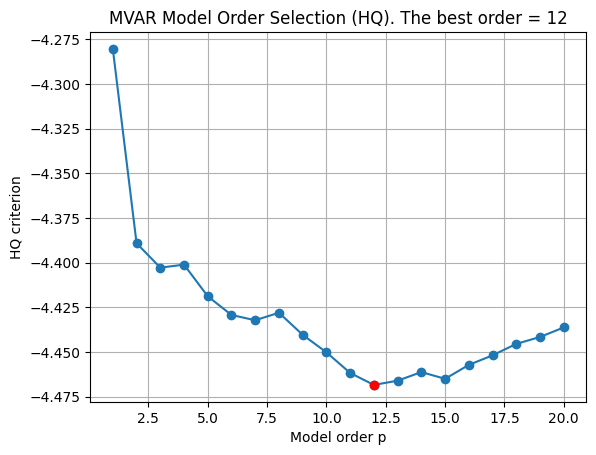

  Optimal model order: p = 12

Processing channel pair: 0 ↔ 2


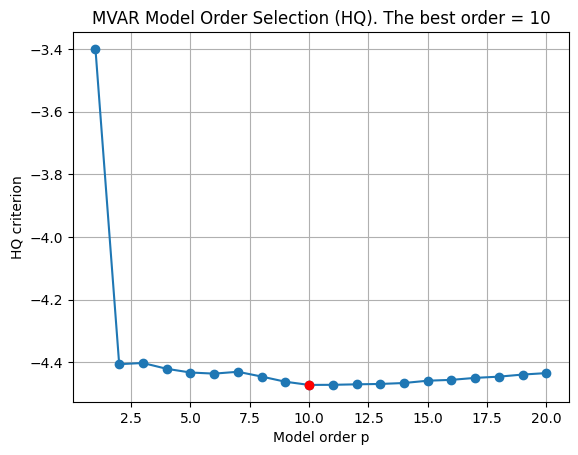

  Optimal model order: p = 10

Processing channel pair: 1 ↔ 2


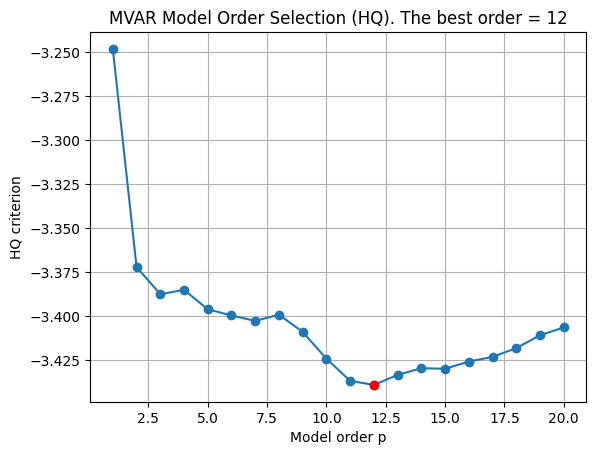

  Optimal model order: p = 12

✓ Bivariate spectral analysis completed!


In [27]:
print("=== BIVARIATE SPECTRAL ANALYSIS ===")
print("Analyzing each channel pair separately...")

# Initialize the bivariate spectrum
S_bivariate = np.zeros((N_chan, N_chan, N_f), dtype=np.complex128)

# Process each channel pair
for ch1 in range(N_chan):
    for ch2 in range(ch1+1, N_chan):
        print(f"\nProcessing channel pair: {ch1} ↔ {ch2}")

        # Create bivariate signal
        x = np.vstack((sim1[ch1, :], sim1[ch2, :]))

        # Estimate optimal model order for this pair
        crit, p_range, p_opt = mvar_criterion(x, max_p, crit_type, True)
        print(f"  Optimal model order: p = {p_opt}")

        # Estimate AR coefficients and compute transfer function
        Ar, V = AR_coeff(x, p_opt)
        H, _ = mvar_H(Ar, f, Fs)

        # Compute spectrum for this channel pair
        S_2chan = np.zeros((2, 2, N_f), dtype=np.complex128)
        for fi in range(N_f):
            S_2chan[:, :, fi] = H[:, :, fi].dot(V.dot(H[:, :, fi].T))

        # Store results in the global bivariate spectrum matrix
        S_bivariate[ch1, ch1, :] = S_2chan[0, 0, :]
        S_bivariate[ch2, ch2, :] = S_2chan[1, 1, :]
        S_bivariate[ch1, ch2, :] = S_2chan[0, 1, :]
        S_bivariate[ch2, ch1, :] = S_2chan[1, 0, :]

print("\n✓ Bivariate spectral analysis completed!")

## Multivariate Approach

In the multivariate approach, we estimate the model order for all channels simultaneously. This provides a more comprehensive view of the system dynamics.

=== MULTIVARIATE SPECTRAL ANALYSIS ===
Analyzing all channels simultaneously...


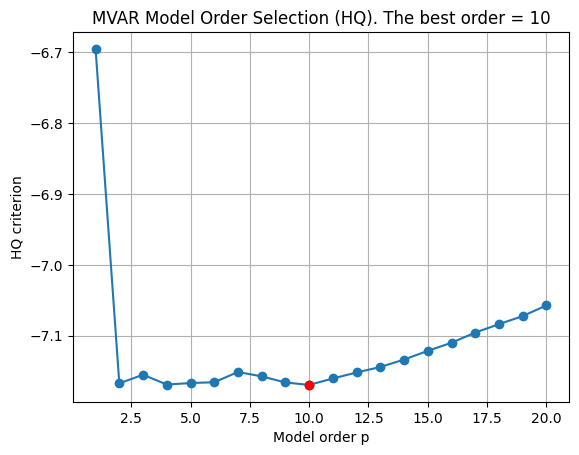

Optimal model order for all channels: p = 10
✓ Multivariate spectral analysis completed!

=== MODEL ORDER COMPARISON ===
Note: The multivariate approach typically results in more parsimonious models
while the bivariate approach may overfit with higher model orders.


In [28]:
print("=== MULTIVARIATE SPECTRAL ANALYSIS ===")
print("Analyzing all channels simultaneously...")

# Use all channels together
x = sim1

# Estimate optimal model order for all channels
crit, p_range, p_opt = mvar_criterion(x, max_p, crit_type, True)
print(f"Optimal model order for all channels: p = {p_opt}")

# Estimate AR coefficients and compute transfer function
Ar, V = AR_coeff(x, p_opt)
H, _ = mvar_H(Ar, f, Fs)

# Compute multivariate spectrum
S_multivariate = np.zeros((N_chan, N_chan, N_f), dtype=np.complex128)
for fi in range(N_f):
    S_multivariate[:, :, fi] = H[:, :, fi].dot(V.dot(H[:, :, fi].T))

print("✓ Multivariate spectral analysis completed!")

# Display model order comparison
print(f"\n=== MODEL ORDER COMPARISON ===")
print("Note: The multivariate approach typically results in more parsimonious models")
print("while the bivariate approach may overfit with higher model orders.")

## Visualization of Spectral

Let's create plots to compare the bivariate and multivariate spectral estimates:

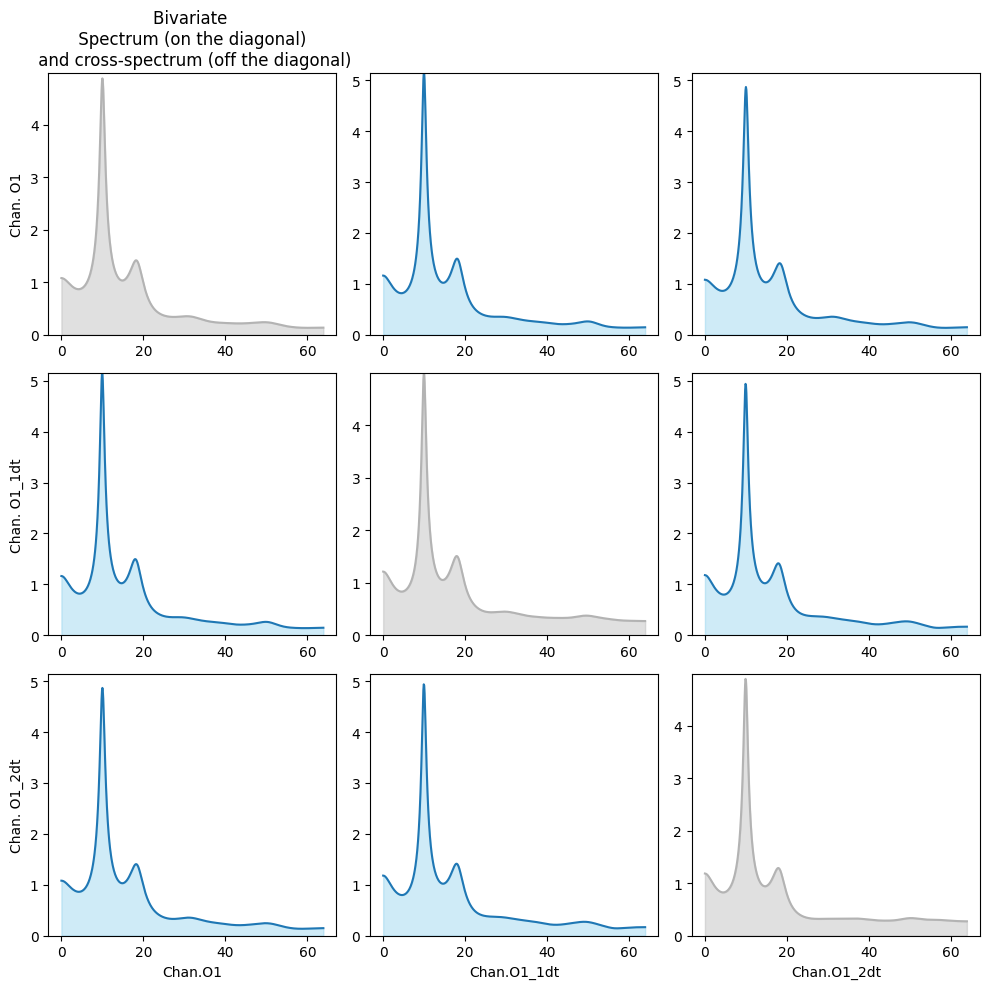

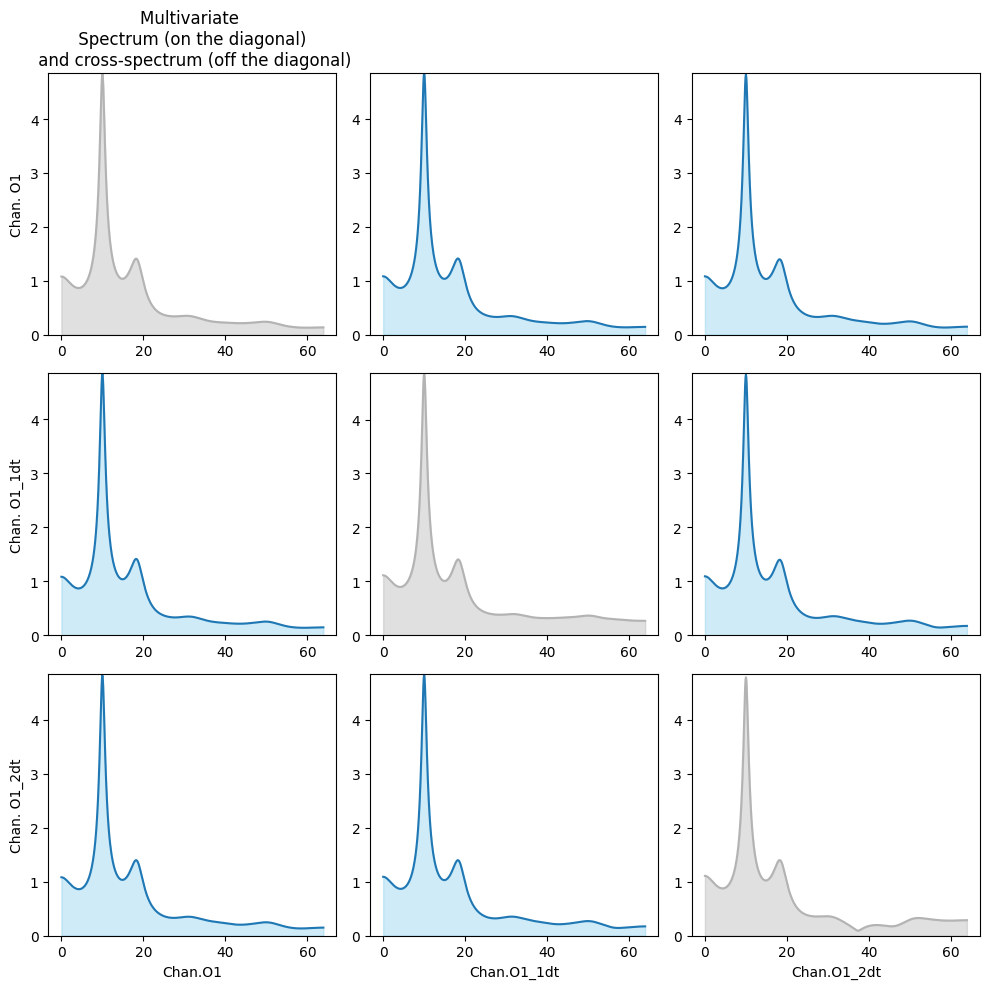

In [29]:
chan_list = [i for i in data['channels'].keys()]
mvar_plot(S_bivariate, S_bivariate, f, 'Chan.', 'Chan. ',chan_list, 'Bivariate \n Spectrum (on the diagonal) \n and cross-spectrum (off the diagonal)','sqrt')

mvar_plot(S_multivariate, S_multivariate, f, 'Chan.', 'Chan. ',chan_list, 'Multivariate \n Spectrum (on the diagonal) \n and cross-spectrum (off the diagonal)','sqrt')
plt.show()

## Spectral Analysis Results

**Key Observations:**

1. **Diagonal Elements (Auto-spectra)**: Show the power spectral density of each individual channel
2. **Off-diagonal Elements (Cross-spectra)**: Reveal the spectral coupling between channel pairs
3. **Alpha Peak**: Look for the characteristic alpha rhythm peak around 8-12 Hz
4. **Approach Differences**: Compare the spectral profiles between bivariate and multivariate methods

**Expected Differences:**
- Qualitatively very similar
- Bivariate approach may show **narrower spectral peaks** due to higher model orders
- Multivariate approach provides a **more integrated view** of the system dynamics

# DIRECTED TRANSFER FUNCTION (DTF) ANALYSIS

Now let's compute the Directed Transfer Function to analyze directional connectivity patterns.

## Bivariate DTF Computation

In [30]:
print("=== BIVARIATE DTF ANALYSIS ===")
print("Computing DTF for each channel pair separately...")

# Initialize the bivariate DTF
DTF_bivariate = np.zeros((N_chan, N_chan, N_f), dtype=np.complex128)

# Process each channel pair for DTF
for ch1 in range(N_chan):
    for ch2 in range(ch1+1, N_chan):
        print(f"Computing DTF for channel pair: {ch1} ↔ {ch2}")

        # Create bivariate signal
        x = np.vstack((sim1[ch1, :], sim1[ch2, :]))

        # Estimate model parameters
        _, _, p_opt = mvar_criterion(x, max_p, crit_type, False)
        Ar, _ = AR_coeff(x, p_opt)
        H, _ = mvar_H(Ar, f, Fs)

        # Compute DTF (squared magnitude of transfer function)
        DTF_2chan = np.abs(H)**2

        # Store in the global DTF matrix
        DTF_bivariate[ch1, ch2, :] = DTF_2chan[0, 1, :]  # ch1 → ch2
        DTF_bivariate[ch2, ch1, :] = DTF_2chan[1, 0, :]  # ch2 → ch1

print("✓ Bivariate DTF computation completed!")

=== BIVARIATE DTF ANALYSIS ===
Computing DTF for each channel pair separately...
Computing DTF for channel pair: 0 ↔ 1
Computing DTF for channel pair: 0 ↔ 2
Computing DTF for channel pair: 1 ↔ 2
✓ Bivariate DTF computation completed!


## Multivariate DTF Computation

In [31]:
print("=== MULTIVARIATE DTF ANALYSIS ===")
print("Computing DTF for all channels simultaneously...")

# Estimate model parameters for all channels
_, _, p_opt = mvar_criterion(sim1, max_p, crit_type, False)
print(f"Using model order: p = {p_opt}")

Ar, _ = AR_coeff(sim1, p_opt)
H, _ = mvar_H(Ar, f, Fs)

# Compute multivariate DTF
DTF_multivariate = np.abs(H)**2

print("✓ Multivariate DTF computation completed!")

print(f"\n=== DTF ANALYSIS SUMMARY ===")
print(f"DTF matrices computed with {N_f} frequency points")
print(f"Frequency range: {f[0]:.1f} - {f[-1]:.1f} Hz")
print("DTF values represent directional information flow between channels")

=== MULTIVARIATE DTF ANALYSIS ===
Computing DTF for all channels simultaneously...
Using model order: p = 10
✓ Multivariate DTF computation completed!

=== DTF ANALYSIS SUMMARY ===
DTF matrices computed with 640 frequency points
Frequency range: 0.0 - 63.9 Hz
DTF values represent directional information flow between channels


## Interactive DTF Visualization

Let's create comprehensive interactive visualizations of the DTF results:

/content/mtmvar.py:199: UserWarning:

The figure layout has changed to tight



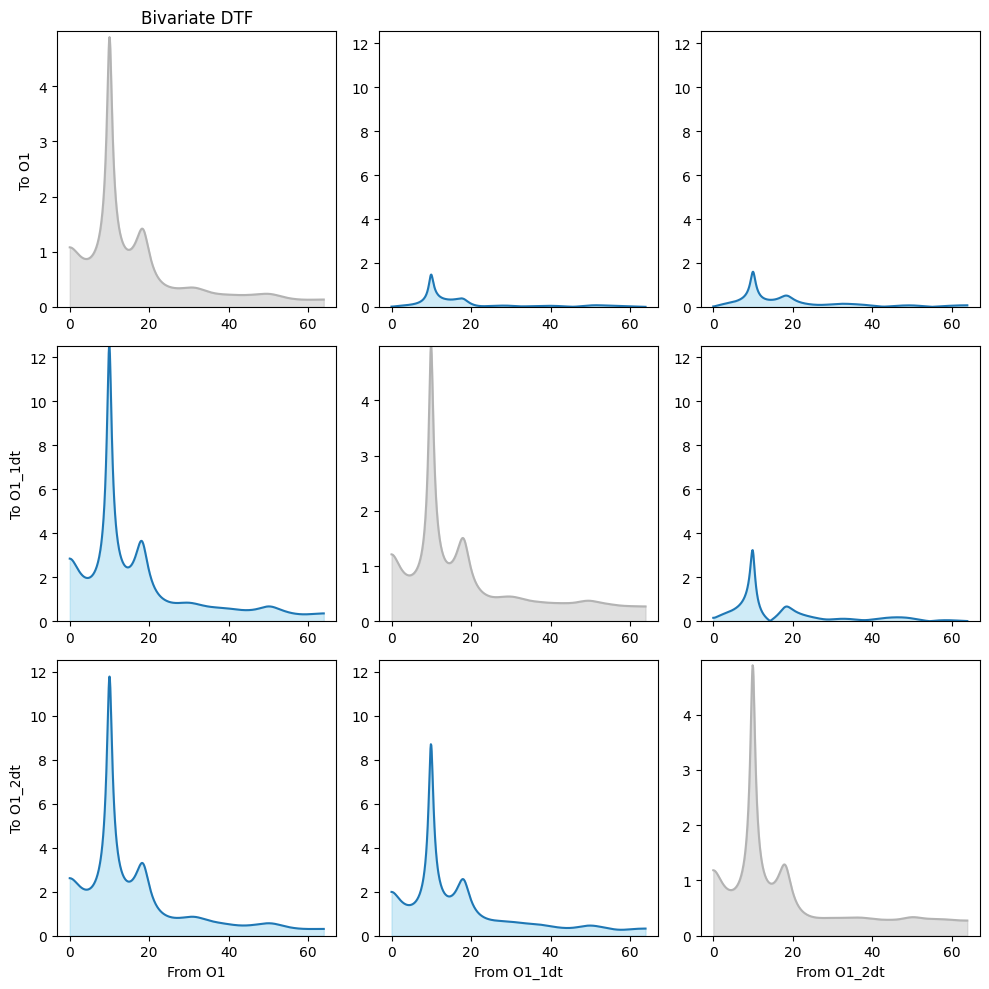

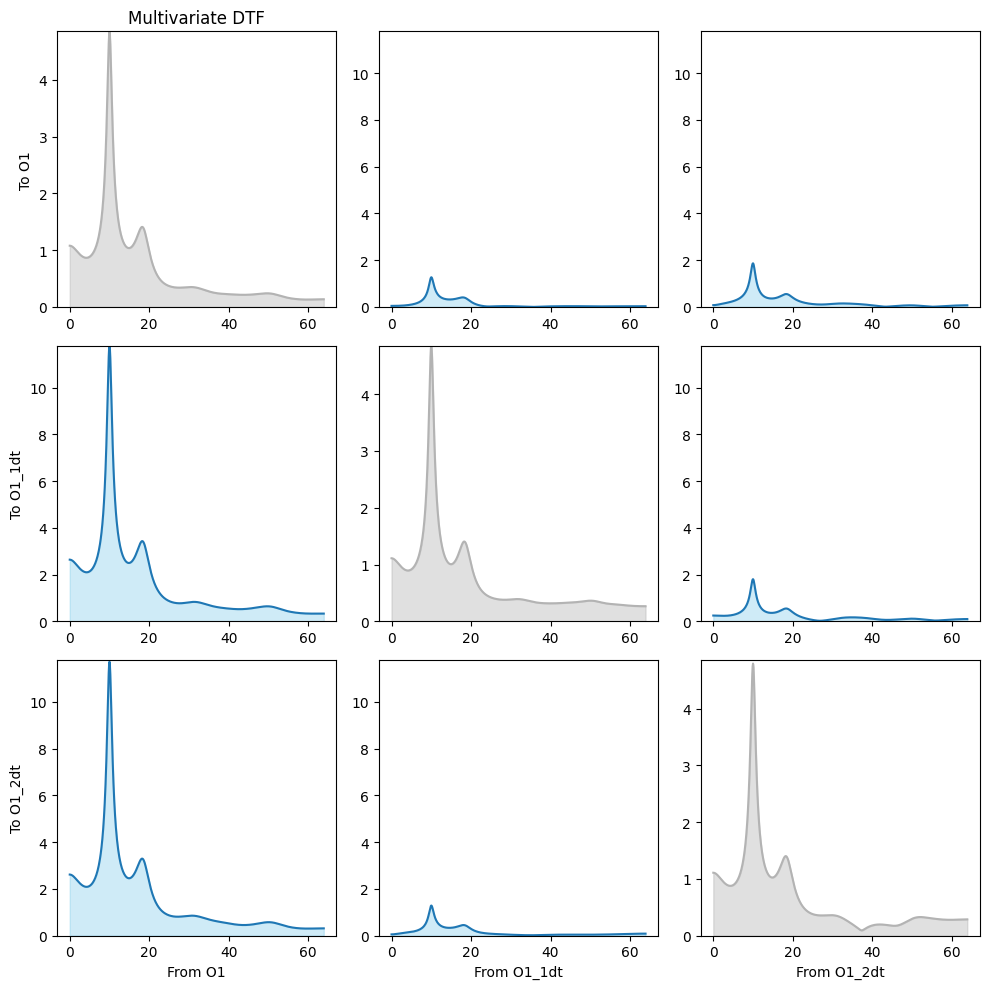

In [34]:
chan_list = [i for i in data['channels'].keys()]
mvar_plot(S_bivariate, DTF_bivariate,   f, 'From ', 'To ',chan_list, 'Bivariate DTF' ,'sqrt')
plt.show()
mvar_plot(S_multivariate, DTF_multivariate,   f, 'From ', 'To ',chan_list, 'Multivariate DTF' ,'sqrt')
plt.show()

## Traditional Network Visualization

Create the traditional matplotlib network plots:

In [35]:
# Traditional matplotlib network visualization
def create_matplotlib_network_comparison():
    """Create side-by-side network plots using matplotlib"""

    plt.figure(figsize=(12, 5))

    # Use consistent layout
    pos = nx.spring_layout(G_multivariate, seed=42)

    # Bivariate network
    plt.subplot(1, 2, 1)
    linewidths_biv = get_linewidths(G_bivariate)

    nx.draw(G_bivariate, pos, with_labels=True, arrows=True,
            width=linewidths_biv if len(linewidths_biv) > 0 else 1,
            node_size=1000,
            arrowstyle='->',
            arrowsize=20,
            connectionstyle='arc3,rad=0.2',
            node_color='lightblue',
            font_size=14,
            font_weight='bold')
    plt.title('Bivariate DTF Network', fontsize=14, fontweight='bold')

    # Multivariate network
    plt.subplot(1, 2, 2)
    linewidths_mult = get_linewidths(G_multivariate)

    nx.draw(G_multivariate, pos, with_labels=True, arrows=True,
            width=linewidths_mult if len(linewidths_mult) > 0 else 1,
            node_size=1000,
            arrowstyle='->',
            arrowsize=20,
            connectionstyle='arc3,rad=0.2',
            node_color='lightcoral',
            font_size=14,
            font_weight='bold')
    plt.title('Multivariate DTF Network', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Create the comparison plot
create_matplotlib_network_comparison()

NameError: name 'G_multivariate' is not defined

<Figure size 1200x500 with 0 Axes>

# COMPREHENSIVE ANALYSIS RESULTS

## Key Findings and Interpretation

### Spectral Analysis Comparison
- **Bivariate approach**: Shows higher model orders and potentially narrower spectral peaks
- **Multivariate approach**: More parsimonious models with broader spectral features
- **Cross-spectral patterns**: Differences in coupling estimates between approaches

### DTF Connectivity Analysis
- **Bivariate DTF**: May show spurious connections due to indirect pathways
- **Multivariate DTF**: Better at revealing true direct connections
- **Directional patterns**: Compare the flow patterns between the two approaches

### Network Topology
- **Node colors**: Red = information sources, Blue = information sinks
- **Edge thickness**: Proportional to connection strength
- **Network density**: Compare the number and strength of connections

## Detailed Conclusions

### When estimating spectra and cross-spectra:
1. **Similar overall patterns** between bivariate and multivariate approaches
2. **Higher model orders** in bivariate approach lead to narrower spectral peaks
3. **Computational complexity** is higher for bivariate analysis, especially with many channels

### For DTF connectivity analysis:
1. **Spurious connections** are more common in bivariate DTF estimates
2. **Multivariate DTF** provides more accurate representation of direct connections
3. **Indirect effects** are better controlled in the multivariate approach

### Practical recommendations:
- **Use multivariate approach** when possible for more accurate connectivity estimates
- **Bivariate approach** may be necessary for very high-dimensional data due to computational constraints
- **Model order selection** is crucial for both approaches
- **Frequency-specific analysis** reveals important temporal dynamics

## Further Reading and Advanced Topics

### Extended Analysis Methods:
- **Partial Directed Coherence (PDC)**: Alternative to DTF with different normalization
- **Granger Causality**: Statistical approach to directional connectivity
- **Time-varying connectivity**: Analysis of dynamic changes in connectivity
- **Statistical significance testing**: Surrogate data methods for connectivity validation

### Technical Considerations:
- **Stationarity requirements**: MVAR models assume stationary signals
- **Model order selection**: Different criteria (AIC, BIC, HQ) may give different results
- **Frequency resolution**: Trade-off between frequency and time resolution
- **Multiple comparison correction**: Important when analyzing many connections

### Applications:
- **EEG/MEG connectivity analysis**
- **fMRI effective connectivity**
- **Economic time series analysis**
- **Climate data connectivity patterns**

---

**This notebook demonstrates the fundamental differences between bivariate and multivariate approaches to connectivity estimation, providing a foundation for more advanced connectivity analysis methods.**